## 准备数据

In [1]:
import os
import datetime

def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)

printbar()


================================================================================2021-02-02 15:20:56


In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets

In [3]:
transform_train = transforms.Compose([
    transforms.ToTensor()
])

transform_valid = transforms.Compose([
    transforms.ToTensor()
])

In [4]:
ds_train = datasets.ImageFolder('./data/cifar2/train/', transform=transform_train, target_transform= lambda t : torch.tensor([t]).float())
ds_valid = datasets.ImageFolder('./data/cifar2/test/', transform=transform_valid, target_transform= lambda t : torch.tensor([t]).float())

print(ds_train.class_to_idx)


{'0_airplane': 0, '1_automobile': 1}


In [5]:
dl_train = DataLoader(dataset=ds_train, batch_size=50, shuffle=True)
dl_valid = DataLoader(dataset=ds_valid, batch_size=50, shuffle=True)

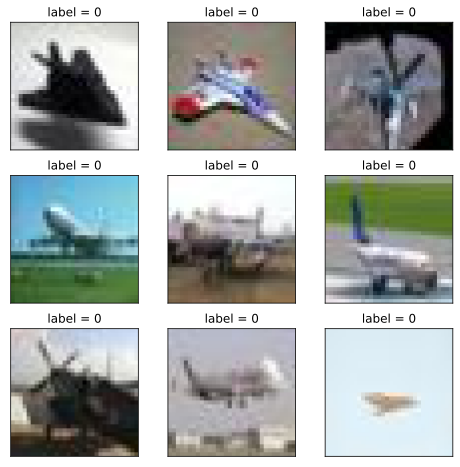

In [6]:
%config InlineBackend.figure_format = 'svg'

#查看部分样本
from matplotlib import pyplot as plt 

plt.figure(figsize=(8,8)) 
for i in range(9):
    img,label = ds_train[i]
    img = img.permute(1,2,0)
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label.item())
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()

In [7]:
for x, y in dl_train:
    print(x.shape)
    print(y.shape)
    break

torch.Size([50, 3, 32, 32])
torch.Size([50, 1])


## 定义模型

In [9]:
pool = nn.AdaptiveMaxPool2d((1, 1))
t = torch.randn(10, 8, 32, 32)
pool(t).shape

torch.Size([10, 8, 1, 1])

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)
        self.dropout = nn.Dropout(p=0.1)
        self.adaptive_pool = nn.AdaptiveMaxPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(64, 32)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = self.adaptive_pool(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        y = self.sigmoid(x)
        return y

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout(p=0.1, inplace=False)
  (adaptive_pool): AdaptiveMaxPool2d(output_size=(1, 1))
  (flatten): Flatten()
  (linear1): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [11]:
import torchkeras

torchkeras.summary(net, input_shape=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
         MaxPool2d-2           [-1, 32, 15, 15]               0
            Conv2d-3           [-1, 64, 11, 11]          51,264
         MaxPool2d-4             [-1, 64, 5, 5]               0
           Dropout-5             [-1, 64, 5, 5]               0
 AdaptiveMaxPool2d-6             [-1, 64, 1, 1]               0
           Flatten-7                   [-1, 64]               0
            Linear-8                   [-1, 32]           2,080
              ReLU-9                   [-1, 32]               0
           Linear-10                    [-1, 1]              33
          Sigmoid-11                    [-1, 1]               0
Total params: 54,273
Trainable params: 54,273
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.011719
Forwar

## 训练模型

In [12]:
import pandas as pd
from sklearn.metrics import roc_auc_score

model = net
model.optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)
model.loss_func = torch.nn.BCELoss()
model.metric_func = lambda y_pred,y_true: roc_auc_score(y_true.data.numpy(),y_pred.data.numpy())
model.metric_name = "auc"


In [13]:
def train_step(model, features, labels):
    # 训练模式
    model.train()
    # 梯度清零
    model.optimizer.zero_grad()
    # 正向传播
    pred = model(features)
    loss = model.loss_func(pred, labels)
    metric = model.metric_func(pred, labels)
    # 反向传播
    loss.backward()
    model.optimizer.step()
    return loss.item(), metric.item()


def valid_step(model, features, labels):
    # 预测模式
    model.eval()
    with torch.no_grad():
        pred = model(features)
        loss = model.loss_func(pred, labels)
        metric = model.metric_func(pred, labels)
    return loss.item(), metric.item()


features, labels = next(iter(dl_train))
train_step(model, features, labels)


(0.6817187666893005, 0.7522281639928698)

In [14]:
def train_model(model, epochs, dl_train, dl_valid, log_step_freq):
    metric_name = model.metric_name
    dfhistory = pd.DataFrame(columns = ["epoch","loss",metric_name,"val_loss","val_"+metric_name]) 
    print("Start Training...")
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("=========="*8 + "%s"%nowtime)

    for epoch in range(1, epochs+1):

        # 1，训练循环
        loss_sum = 0.0
        metric_sum = 0.0
        step = 1
        for step, (features, labels) in enumerate(dl_train, 1):
            loss, metric = train_step(model, features, labels)
            loss_sum += loss
            metric_sum += metric
            if step%log_step_freq == 0:   
                print(("[step = %d] loss: %.3f, "+metric_name+": %.3f") %
                      (step, loss_sum/step, metric_sum/step))
        
        # 2，验证循环
        val_loss_sum = 0.0
        val_metric_sum = 0.0
        val_step = 1
        for val_step, (features,labels) in enumerate(dl_valid, 1):

            val_loss,val_metric = valid_step(model,features,labels)

            val_loss_sum += val_loss
            val_metric_sum += val_metric

        # 3，记录日志
        info = (epoch, loss_sum/step, metric_sum/step, 
                val_loss_sum/val_step, val_metric_sum/val_step)
        dfhistory.loc[epoch-1] = info

        # 打印epoch级别日志
        print(("\nEPOCH = %d, loss = %.3f,"+ metric_name + \
              "  = %.3f, val_loss = %.3f, "+"val_"+ metric_name+" = %.3f") 
              %info)
        nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        print("\n"+"=========="*8 + "%s"%nowtime)
        
    print('Finished Training...')
    
    return dfhistory


In [15]:
epochs = 20

dfhistory = train_model(model,epochs,dl_train,dl_valid,log_step_freq = 50)

Start Training...
================================================================================2021-02-02 16:10:47
[step = 50] loss: 0.692, auc: 0.706
[step = 100] loss: 0.690, auc: 0.727
[step = 150] loss: 0.689, auc: 0.741
[step = 200] loss: 0.687, auc: 0.754

EPOCH = 1, loss = 0.687,auc  = 0.754, val_loss = 0.682, val_auc = 0.800

================================================================================2021-02-02 16:11:55
[step = 50] loss: 0.680, auc: 0.788
[step = 100] loss: 0.677, auc: 0.794
[step = 150] loss: 0.676, auc: 0.788
[step = 200] loss: 0.673, auc: 0.788

EPOCH = 2, loss = 0.673,auc  = 0.788, val_loss = 0.664, val_auc = 0.817

================================================================================2021-02-02 16:12:04
[step = 50] loss: 0.661, auc: 0.786
[step = 100] loss: 0.657, auc: 0.790
[step = 150] loss: 0.652, auc: 0.799
[step = 200] loss: 0.647, auc: 0.798

EPOCH = 3, loss = 0.647,auc  = 0.798, val_loss = 0.625, val_auc = 0.822

===================

## 评估模型

In [16]:
dfhistory

,epoch,loss,auc,val_loss,val_auc
0,1.0,0.687294,0.754324,0.682182,0.800457
1,2.0,0.673185,0.787950,0.663766,0.816745
2,3.0,0.647015,0.798119,0.625440,0.821694
3,4.0,0.597181,0.804869,0.559136,0.835365
4,5.0,0.545648,0.816957,0.507678,0.848517
5,6.0,0.516812,0.828971,0.491865,0.860641
6,7.0,0.499000,0.841777,0.498741,0.864399
7,8.0,0.485547,0.851253,0.463495,0.871743
8,9.0,0.474022,0.859168,0.438837,0.880521
9,10.0,0.460030,0.867758,0.448872,0.886575


In [17]:
import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

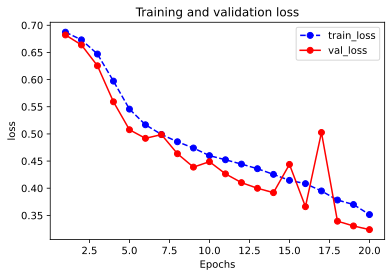

In [18]:
plot_metric(dfhistory,"loss")

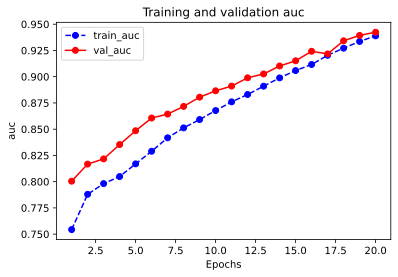

In [19]:
plot_metric(dfhistory,"auc")